As a toy example We start from learning sine curve.

In [2]:
import numpy as np

np.random.seed(2)

T = 2
L = 50
N = 1000

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')

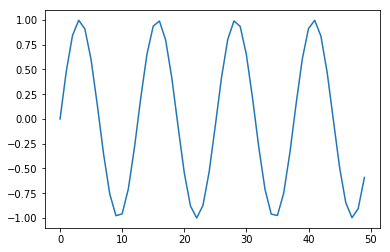

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x[0], data[0]);

In [4]:


train_input = torch.from_numpy(data[3:, :-1, None]).float()
train_target = torch.from_numpy(data[3:, 1:, None]).float()
test_input = torch.from_numpy(data[:3, :-1, None]).float()
test_target = torch.from_numpy(data[:3, 1:, None]).float()

NameError: name 'torch' is not defined

In [1]:
import bayes_nn

In [56]:
class LockedDropout(nn.Module):
    def __init__(self, dropout=0., batch_first=True):
        super(LockedDropout, self).__init__()
        self.dropout = dropout
        self.batch_first = batch_first
        self.mask = None

    def forward(self, x, fixed=False):
        if not self.training or not self.dropout:
            return x
        if self.batch_first:
            m = x.data.new(x.size(0), 1, x.size(2)).bernoulli_(1 - self.dropout)
        else:
            m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - self.dropout)
        if self.mask is None or not fixed:
            self.mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = self.mask.expand_as(x)
        return mask * x
    

class WeightDrop(torch.nn.Module):
    def __init__(self, module, weights, dropout=0):
        super(WeightDrop, self).__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self._setup()

    def widget_demagnetizer_y2k_edition(*args, **kwargs):
        # We need to replace flatten_parameters with a nothing function
        # It must be a function rather than a lambda as otherwise pickling explodes
        # We can't write boring code though, so ... WIDGET DEMAGNETIZER Y2K EDITION!
        # (╯°□°）╯︵ ┻━┻
        return

    def _setup(self):
        # Terrible temporary solution to an issue regarding compacting weights re: CUDNN RNN
        if issubclass(type(self.module), torch.nn.RNNBase):
            self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

        for name_w in self.weights:
            print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = F.dropout(raw_w, p=self.dropout, training=self.training)
            setattr(self.module, name_w, w)

    def forward(self, x, hidden=None, fixed=False, *args, **kwargs):
        if not fixed:
            self._setweights()
        return self.module.forward(x, hidden, *args, **kwargs)

In [98]:
class MCDropoutLSTM(nn.Module):
    def __init__(self, n_input, n_hidden, n_output=1, n_layer=2,
                 idrop=.25, drop=.25, wdrop=.25, batch_first=True):
        super(MCDropoutLSTM, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.n_layers = n_layers
        self.idrop = idrop
        self.drop = drop
        self.wdrop = wdrop
        self.rnns = [
            nn.LSTM(n_input if i == 0 else n_hidden,
                    n_hidden, num_layers=1, batch_first=batch_first)
            for i in range(n_layers)
        ]
        # Fixed Dropout
        self.inputdrop = LockedDropout(idrop, batch_first)
        self.lockdrops = [LockedDropout(drop, batch_first) for i in range(n_layers)]
        # Recurrent weight dropout
        if self.wdrop:
            self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop)
                         for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.output_layer = nn.Linear(n_hidden, n_output)
        
    def _forward(self, x, hidden=None, fixed=False):
        x = self.inputdrop(x, fixed=fixed)
        new_hs = []
        new_cs = []
        for i, rnn in enumerate(self.rnns):
            if hidden is None:
                hidden_i = None
            else:
                hidden_i = (hidden[0][[i]], hidden[1][[i]])
            x, (new_h, new_c) = rnn(x, hidden=hidden_i, fixed=fixed)
            x = self.lockdrops[i](x, fixed=fixed)
            new_hs.append(new_h)
            new_cs.append(new_c)
        new_hs = torch.cat(new_hs, 0)
        new_cs = torch.cat(new_cs, 0)
        output = self.output_layer(x)
        return output, (new_hs, new_cs)
    
    def forward(self, x, hidden=None, forward=0):
        output, hidden = self._forward(x, hidden, fixed=False)
        if forward > 0:
            preds = []
            pred_input = output[:, [-1]]
            pred_hidden = hidden
            for i in range(forward):
                pred, pred_hidden = self._forward(pred_input, pred_hidden, fixed=True)
                preds.append(pred)
                pred_input = pred
            preds = torch.cat(preds, 1)
            hidden = pred_hidden
            output = torch.cat([output, preds], 1)
        return output

In [99]:
class MyDataset(tdata.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [132]:
from tqdm import tqdm_notebook

def train(model, optimizer, dataset, num_epochs, batch_size=64, shuffle=True):
    dataloader = tdata.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    for i in tqdm_notebook(range(num_epochs)):
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        if i % 10 == 0:
            print(i, epoch_loss)
        epoch_loss = 0

In [133]:
n_input = 1
n_output = 1
n_hidden = 128
n_layers = 2
num_epochs = 100

model = MCDropoutLSTM(n_input, n_hidden, n_output, n_layers, idrop=.2, drop=.2, wdrop=.2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = MyDataset(train_input, train_target)
criterion = nn.MSELoss()

train(model, optimizer, dataset, num_epochs)

Applying weight drop of 0.2 to weight_hh_l0
Applying weight drop of 0.2 to weight_hh_l0


HBox(children=(IntProgress(value=0), HTML(value='')))

0 7.35832080245018
10 1.8043321892619133
20 1.7573790326714516
30 1.7912226244807243
40 1.8662892132997513
50 1.8772214129567146
60 1.5505094267427921
70 1.6941161826252937


KeyboardInterrupt: 

In [134]:
T = 50
forward = 100
outputs = []
for t in range(T):
    output = model(test_input, forward=forward).detach().numpy()
    outputs.append(output)
pred_mean = np.mean(outputs, axis=0)[:, :, 0]
pred_sig = np.std(outputs, axis=0)[:, :, 0]

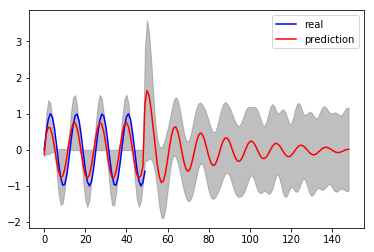

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline

idx = 0

x_plot = x[idx]
y_plot = data[idx]
pred_x = np.arange(x_plot[0], len(pred_mean[idx]))

plt.plot(x_plot, y_plot, label='real', color='b')
plt.plot(pred_x, pred_mean[idx], label='prediction', color='r')
plt.fill_between(pred_x,
                 pred_mean[idx] - 2 * pred_sig[idx],
                 pred_mean[idx] + 2 * pred_sig[idx],
                 color='gray', alpha=.5)
plt.legend()

In [136]:
help(model.train)

Help on method train in module torch.nn.modules.module:

train(mode=True) method of __main__.MCDropoutLSTM instance
    Sets the module in training mode.
    
    This has any effect only on certain modules. See documentations of
    particular modules for details of their behaviors in training/evaluation
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
    etc.
    
    Returns:
        Module: self

